

---
# Downloading Dataset


---





In [17]:
!wget https://www.dropbox.com/s/qigdf9klmejsk62/flight_delay.csv

--2021-09-24 18:15:17--  https://www.dropbox.com/s/qigdf9klmejsk62/flight_delay.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qigdf9klmejsk62/flight_delay.csv [following]
--2021-09-24 18:15:17--  https://www.dropbox.com/s/raw/qigdf9klmejsk62/flight_delay.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1067d37d1610f3910de478ae14.dl.dropboxusercontent.com/cd/0/inline/BWx6TPKmepspFGCQQ5qfBxSVLv6VhYE4eEE6oQj3zX_DgN1EChXACktZOuTqA8brDk6lWZZpdvxUx1OvfwSrSI8-awPooOP95gnt1QpMbwS-6csSrPSINSfnlGfolEW7RIbcPDdCUlUWQqsJKByDm7lC/file# [following]
--2021-09-24 18:15:17--  https://uc1067d37d1610f3910de478ae14.dl.dropboxusercontent.com/cd/0/inline/BWx6TPKmepspFGCQQ5qfBxSVLv6VhYE4eEE6oQj3zX_DgN1EChXACktZOuTqA8brDk6lWZZpdvxUx1



---
# Imports


---





In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import decomposition, preprocessing, feature_selection, linear_model, model_selection



---
# Pre-processing


---




In [19]:
df = pd.read_csv('/content/flight_delay.csv')
df.head()

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0


In [20]:
df.describe()

,Delay
count,675513.000000
mean,9.912939
std,44.895875
min,0.000000
25%,0.000000
50%,0.000000
75%,5.000000
max,1436.000000


In [21]:
# Expanding Departure and Arrival timestamps columns into days, months, years and flight duration

departure_series = pd.to_datetime(df['Scheduled depature time'])
arrival_series = pd.to_datetime(df['Scheduled arrival time'])

# Adding flight duration column

df['Flight duration'] = [abs(x).total_seconds() / 3600.0 for x in (departure_series - arrival_series)]

# Expanding Departure timestamps

df['Depature year'] = departure_series.dt.year
df['Depature month'] = departure_series.dt.month
df['Depature day'] = departure_series.dt.day
df['Depature weekday'] = departure_series.dt.dayofweek
df['Depature hour'] = departure_series.dt.hour
df.drop('Scheduled depature time', inplace=True, axis=1)

# Using only hours from arrival timestamp

df['Arrival hour'] = arrival_series.dt.hour
df.drop('Scheduled arrival time', inplace=True, axis=1)

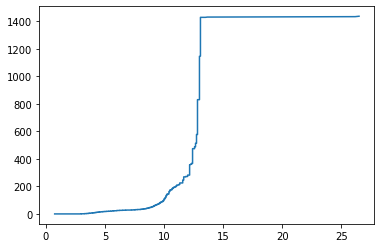

In [22]:
plt.plot(sorted(df['Flight duration']), sorted(df['Delay']))
plt.show()

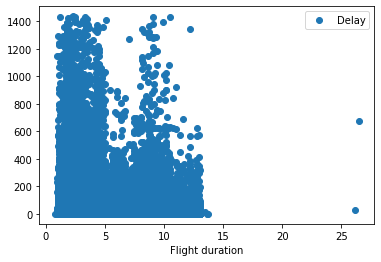

In [23]:
df.plot(x='Flight duration',
                      y='Delay',
                      style='o')

plt.show()

In [24]:
df['Delay'].value_counts()

0.0       391070
1.0        38963
2.0        28729
3.0        22501
4.0        17167
           ...  
706.0          1
1284.0         1
1042.0         1
1037.0         1
1002.0         1
Name: Delay, Length: 1075, dtype: int64

In [25]:
# Detecting and Removing Outliers using The interquartile range (IQR)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

print('\nShape before outliers:', df.shape)
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print('Shape after outliers:', df.shape)

Delay                5.00
Flight duration      1.75
Depature year        2.00
Depature month       5.00
Depature day        15.00
Depature weekday     4.00
Depature hour       11.00
Arrival hour        11.00
dtype: float64

Shape before outliers: (675513, 10)
Shape after outliers: (538770, 10)


In [26]:
# One hot encoding the Airport names

df = pd.get_dummies(df, columns = ['Depature Airport', 'Destination Airport'], drop_first=True)

# Moving target column to the end

df['Delay'] = df.pop('Delay')
df.head()

,Flight duration,Depature year,Depature month,Depature day,Depature weekday,Depature hour,Arrival hour,Depature Airport_ABA,Depature Airport_AER,Depature Airport_AGP,Depature Airport_AKX,Depature Airport_ALA,Depature Airport_ALC,Depature Airport_AMS,Depature Airport_ARH,Depature Airport_ARN,Depature Airport_ASF,Depature Airport_ATH,Depature Airport_AYT,Depature Airport_BAX,Depature Airport_BCN,Depature Airport_BEG,Depature Airport_BEY,Depature Airport_BLQ,Depature Airport_BOJ,Depature Airport_BRU,Depature Airport_BSL,Depature Airport_BUD,Depature Airport_CAI,Depature Airport_CDG,Depature Airport_CEK,Depature Airport_CIT,Depature Airport_CPH,Depature Airport_DEL,Depature Airport_DRS,Depature Airport_DUS,Depature Airport_DXB,Depature Airport_EGO,Depature Airport_EIN,Depature Airport_ERZ,...,Destination Airport_SGC,Destination Airport_SIP,Destination Airport_SKD,Destination Airport_SKG,Destination Airport_SKX,Destination Airport_SLY,Destination Airport_SOF,Destination Airport_SPU,Destination Airport_STR,Destination Airport_STW,Destination Airport_SVO,Destination Airport_SVX,Destination Airport_SXF,Destination Airport_SZG,Destination Airport_TAS,Destination Airport_TBS,Destination Airport_TIV,Destination Airport_TJM,Destination Airport_TLL,Destination Airport_TLV,Destination Airport_TOF,Destination Airport_TRN,Destination Airport_TSE,Destination Airport_UFA,Destination Airport_ULN,Destination Airport_VCE,Destination Airport_VIE,Destination Airport_VIT,Destination Airport_VKO,Destination Airport_VLC,Destination Airport_VNO,Destination Airport_VOG,Destination Airport_VOZ,Destination Airport_VRN,Destination Airport_VST,Destination Airport_WAW,Destination Airport_YKS,Destination Airport_ZAG,Destination Airport_ZRH,Delay
4,2.416667,2015,10,27,1,14,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0
5,2.750000,2015,10,27,1,14,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
7,5.666667,2015,10,27,1,15,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
9,4.166667,2015,10,27,1,16,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
10,3.500000,2015,10,27,1,16,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [27]:
# Splitting the Dataset into training and testing

mask = df['Depature year'] == 2018

df_train = df[~mask]
df_test = df[mask]

In [28]:
# Scaling the training data using Robust Scalar (Robust to Outliers)

scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(df_train.drop("Delay", axis=1))
df_train_scaled = pd.DataFrame(X, columns=df_train.drop("Delay", axis=1).columns, index=df_train.index)
x_test = scalerX.fit_transform(df_test.drop("Delay", axis=1))
df_test_scaled = pd.DataFrame(x_test, columns=df_test.drop("Delay", axis=1).columns, index=df_test.index)

scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
df_train_scaled['Delay'] = scalerY.fit_transform(df_train['Delay'].values.reshape(-1,1))
df_test_scaled['Delay'] = scalerY.fit_transform(df_test['Delay'].values.reshape(-1,1))

df_train_scaled.head()

,Flight duration,Depature year,Depature month,Depature day,Depature weekday,Depature hour,Arrival hour,Depature Airport_ABA,Depature Airport_AER,Depature Airport_AGP,Depature Airport_AKX,Depature Airport_ALA,Depature Airport_ALC,Depature Airport_AMS,Depature Airport_ARH,Depature Airport_ARN,Depature Airport_ASF,Depature Airport_ATH,Depature Airport_AYT,Depature Airport_BAX,Depature Airport_BCN,Depature Airport_BEG,Depature Airport_BEY,Depature Airport_BLQ,Depature Airport_BOJ,Depature Airport_BRU,Depature Airport_BSL,Depature Airport_BUD,Depature Airport_CAI,Depature Airport_CDG,Depature Airport_CEK,Depature Airport_CIT,Depature Airport_CPH,Depature Airport_DEL,Depature Airport_DRS,Depature Airport_DUS,Depature Airport_DXB,Depature Airport_EGO,Depature Airport_EIN,Depature Airport_ERZ,...,Destination Airport_SGC,Destination Airport_SIP,Destination Airport_SKD,Destination Airport_SKG,Destination Airport_SKX,Destination Airport_SLY,Destination Airport_SOF,Destination Airport_SPU,Destination Airport_STR,Destination Airport_STW,Destination Airport_SVO,Destination Airport_SVX,Destination Airport_SXF,Destination Airport_SZG,Destination Airport_TAS,Destination Airport_TBS,Destination Airport_TIV,Destination Airport_TJM,Destination Airport_TLL,Destination Airport_TLV,Destination Airport_TOF,Destination Airport_TRN,Destination Airport_TSE,Destination Airport_UFA,Destination Airport_ULN,Destination Airport_VCE,Destination Airport_VIE,Destination Airport_VIT,Destination Airport_VKO,Destination Airport_VLC,Destination Airport_VNO,Destination Airport_VOG,Destination Airport_VOZ,Destination Airport_VRN,Destination Airport_VST,Destination Airport_WAW,Destination Airport_YKS,Destination Airport_ZAG,Destination Airport_ZRH,Delay
4,-0.111111,-1.0,0.5,0.6875,-0.5,0.2,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
5,0.111111,-1.0,0.5,0.6875,-0.5,0.2,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.055556,-1.0,0.5,0.6875,-0.5,0.3,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
9,1.055556,-1.0,0.5,0.6875,-0.5,0.4,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.611111,-1.0,0.5,0.6875,-0.5,0.4,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Feature selection 

X = df_train_scaled.drop('Delay', axis=1).values
y = df_train_scaled['Delay'].values
feature_names = df_train_scaled.drop('Delay', axis=1).columns

# P-value

selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=7).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

# Regularization

selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=7).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [30]:
selected_features = list(set(list(set(pvalue_selected_features) or set(regularization_selected_features))))
print(selected_features)

['Depature Airport_MRV', 'Flight duration', 'Depature Airport_AER', 'Depature hour', 'Arrival hour', 'Depature year', 'Destination Airport_SCW']




---
# Prediction & Evaluation


---




In [31]:
X_names = selected_features
X_train = df_train_scaled[X_names].values
y_train = df_train_scaled['Delay'].to_numpy()

X_test = df_test_scaled[X_names].values
y_test = df_test_scaled['Delay'].to_numpy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(387760, 7) (387760,)
(151010, 7) (151010,)


In [32]:
def get_scores(name, y_test, y_pred):
  mse_score = metrics.mean_squared_error(y_test, y_pred)
  mae_score = metrics.mean_absolute_error(y_test, y_pred)
  r2_score = metrics.r2_score(y_test, y_pred)
  return [name, mse_score, mae_score, r2_score]


ridge = linear_model.Ridge()
decision_tree = DecisionTreeRegressor()
polynomial_features = PolynomialFeatures(2)
linear_regression = linear_model.LinearRegression()
polynomial_regression = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
models = {'Ridge Regression' : ridge, 'Polynomial Regression' :polynomial_regression, 'Decision Tree Regression' : decision_tree}

training_errors, testing_errors = [], []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  training_errors.append(get_scores(name, y_pred_train, y_train))
  testing_errors.append(get_scores(name, y_pred_test, y_test))

score_columns = ['Model', 'MSE_train', 'MAE_train', 'R2_train', 'MSE_test', 'MAE_test', 'R2_test']
train_test_errors = [training_errors[x] + testing_errors[x][1:] for x in range(len(training_errors))]
score_df = pd.DataFrame(train_test_errors, columns=score_columns)
score_df

,Model,MSE_train,MAE_train,R2_train,MSE_test,MAE_test,R2_test
0,Ridge Regression,2.152468,1.095811,-60.023674,3.970498,1.217984,-118.285739
1,Polynomial Regression,2.150067,1.094685,-56.049284,3.975286,1.230815,-110.289447
2,Decision Tree Regression,2.011629,1.031684,-10.421582,4.330247,1.290571,-10.245563
